In [1]:
#@markdown #CMS Diversity Data: Statistics Analysis
#@markdown ###Comparing the USCMS to the full CMS collaboration
#@markdown This notebook will visualize and report the diversity statistics for 
#@markdown the specified country(s) relative to the full CMS collaboration.  The
#@markdown statistics can be filtered by year, gender, role, activity and authorship.
#@markdown ### Import `python` libraries

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import ipywidgets as widgets
from scipy import stats

from google.colab import drive
drive.mount( '/content/drive' )

%cd /content/drive/My Drive/Physics Research/CMS/Analysis/USCMS-diversity-analysis-main/

Mounted at /content/drive
/content/drive/My Drive/Physics Research/CMS/Analysis/USCMS-diversity-analysis-main


In [2]:
#@markdown Import the `json` data file `json_analysis.json`.  This file is created
#@markdown from `combine_json_colab.ipynb` which should be run before this notebook.
#@markdown Display the available years in the `json` file.

with open( "Data/json_analysis.json" ) as json_file:
    data = json.load( json_file )
print( ">> json_analysis.json contains years: {}".format( list( data.keys() ) ) )

>> json_analysis.json contains years: ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [3]:
#@markdown Distinguish between the USCMS institutes and full CMS Collaboration 
#@markdown institutes into separate datasets.
with open( "Data/institutes_new.json" ) as json_file:
    institutes = json.load( json_file )

us_institutes = [ institute["code"] for institute in institutes if institute["country"].lower() == "usa" ]
    
print( ">> Number of CMS institutions: {}".format( len(institutes) ) )
print( ">> Number of USCMS institutions: {}".format( len(us_institutes) ) )

>> Number of CMS institutions: 550
>> Number of USCMS institutions: 82


In [5]:
#@markdown ### Select the filters
#@markdown Selet the project, activities, authorship status and years to report on.
options = {
    "PROJECT": [],
    "ACTIVITY": [],
    "COUNTRY": list( set( [ institute["country"] for institute in institutes ] ) ),
    "AUTHOR": [],
    "YEARS": []
}

for year in list( data.keys() ):
    options[ "YEARS" ].append( year )
    for cms_id in data[ year ]:
        for project in data[ year ][ cms_id ][ "PROJECT" ]:
            if project not in options[ "PROJECT" ]: options[ "PROJECT" ].append( project.upper() )
        if data[ year ][ cms_id ][ "ACTIVITY" ].upper() not in options[ "ACTIVITY" ]: options[ "ACTIVITY" ].append( data[ year ][ cms_id ][ "ACTIVITY" ].upper() )
        if data[ year ][ cms_id ][ "AUTHOR" ]   not in options[ "AUTHOR" ]:   options[ "AUTHOR" ].append( data[ year ][ cms_id ][ "AUTHOR" ] )

In [6]:
#@markdown Select years to report:
years = widgets.SelectMultiple( options = options[ "YEARS" ], value = [ options[ "YEARS"][-1] ] )
years

SelectMultiple(index=(11,), options=('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '…

In [35]:
#@markdown Select authorship status to report:
author_legend = {
    "AUTHORS": [ True ],
    "ALL MEMBERS": [ True, False, None ],
    "NON-AUTHORS:": [ False ],
    "REPORTED MEMBERS": [ True, False ],
    "UNREPORTED MEMBERS": [ None ],
    "AUTHORS and UNREPORTED": [ True, None ],
    "NON-AUTHORS and UNREPORTED": [ False, None ]
}
author = widgets.SelectMultiple( options = options[ "AUTHOR" ], value = [ True ] )
author

SelectMultiple(index=(1,), options=(None, True, False), value=(True,))

In [8]:
#@markdown Select project(s) to report:
projects = widgets.SelectMultiple( options = options[ "PROJECT" ] )
projects

SelectMultiple(options=('HC', 'TRG', 'TECH', 'CORE', 'OFF', 'GEN', 'TK', 'DAQ', 'MURPC', 'RUN', 'EC', 'MUDT', …

In [36]:
#@markdown Select activity(s) to report:
activities = widgets.SelectMultiple( options = options[ "ACTIVITY" ], value = [ "DOCTORAL STUDENT", "PHYSICIST" ] )
activities

SelectMultiple(index=(6, 0), options=('PHYSICIST', 'ENGINEER', 'ENGINEER ELECTRONICS', 'TECHNICIAN', 'ENGINEER…

In [37]:
#@markdown Select country(s) to report (in addition to USCMS):
countries = widgets.SelectMultiple( options = sorted( option.upper() for option in options[ "COUNTRY" ] ) )
countries

SelectMultiple(options=('ARMENIA', 'AUSTRALIA', 'AUSTRIA', 'BAHRAIN', 'BELARUS', 'BELGIUM', 'BRAZIL', 'BULGARI…

In [33]:
#@markdown ### Obtain the filtered statistics
institute_list = np.array( [ list( institute.values() ) for institute in institutes  ] )

countries_label = ""
for country in countries.value:
  if country == countries.value[-1]:
    countries_label += country
  else:
    countries_label += country + ", "

if countries_label == "":
  countries_label = "NONE"

count = {
    str( year ): {
        "MALE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        },
        "FEMALE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        },
        "NONE": {
            countries_label: 0,
            "USCMS": 0,
            "CMS": 0
        }
    } for year in years.value
}

for year in years.value:
    for cms_id in data[ year ]:
        this_index = np.argwhere( institute_list[:,0] == data[ year ][ cms_id ][ "INSTITUTE" ] )[0,0]
        this_country = institute_list[ this_index, 1 ]
        if data[ year ][ cms_id ][ "AUTHOR" ] in list( author.value ):
            if data[ year ][ cms_id ][ "ACTIVITY" ].upper() in list( activities.value ):
                for project in data[ year ][ cms_id ][ "PROJECT" ]:
                    if project.upper() in list( projects.value ):
                        if data[ year ][ cms_id ][ "GENDER" ] == "F":
                            count[ year ][ "FEMALE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "FEMALE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "FEMALE" ][ "USCMS" ] += 1
                        if data[ year ][ cms_id ][ "GENDER" ] == "M":
                            count[ year ][ "MALE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "MALE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "MALE" ][ "USCMS" ] += 1
                        if data[ year ][ cms_id ][ "GENDER" ] == None:
                            count[ year ][ "NONE" ][ "CMS" ] += 1
                            if this_country.upper() in list( countries.value ):
                                count[ year ][ "NONE" ][ countries_label ] += 1
                            if this_country.upper() == "USA":
                                count[ year ][ "NONE" ][ "USCMS" ] += 1

In [34]:
#@markdown ### Report the filtered statistics:
print( "For the following parameters...")
print( ">> Selected years:" )
print( "   o {}".format( list( years.value ) ) )
print( ">> Selected authorship status:" )
print( "   o {}".format( [ str(key) for key in author_legend if list( author.value ) == author_legend[ key ] ] ) )
print( ">> Selected projects:" )
print( "   o {}".format( list( projects.value ) ) )
print( ">> Selected activities:" )
print( "   o {}".format( list( activities.value ) ) )
print( ">> Seleted countries:" )
print( "   o {}".format( list( countries.value ) ) )
print( "\n\n")

for year in years.value:
    cms_total = count[ year ][ "MALE" ][ "CMS" ] + count[ year ][ "FEMALE" ][ "CMS" ] + count[ year ][ "NONE" ][ "CMS" ]
    usa_total = count[ year ][ "MALE" ][ "USCMS" ] + count[ year ][ "FEMALE" ][ "USCMS" ] + count[ year ][ "NONE" ][ "USCMS" ]
    country_total = count[ year ][ "MALE" ][ countries_label ] + count[ year ][ "FEMALE" ][ countries_label ] + count[ year ][ "NONE" ][ countries_label ]
    if cms_total != 0: 
        print( ">> Year: {}".format( year ) )
        print( "   o CMS Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ "CMS" ],
            cms_total,
            100. * float( count[ year ][ "FEMALE" ][ "CMS" ] ) / float( cms_total ) 
        ) )
        print( "   o CMS Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "CMS" ],
            cms_total,
            100. * float( count[ year ][ "MALE" ][ "CMS" ] ) / float( cms_total ) 
        ) )
    else: 
        print( "[ERR] No CMS individuals were found in this category for {}...".format( year ) )
    if usa_total != 0: 
        print( "   o USCMS Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ "USCMS" ],
            usa_total,
            100. * float( count[ year ][ "FEMALE" ][ "USCMS" ] ) / float( usa_total ) 
        ) )
        print( "   o USCMS Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "USCMS" ],
            usa_total,
            100. * float( count[ year ][ "MALE" ][ "USCMS" ] ) / float( usa_total ) 
        ) )
    else: 
        print( "[ERR] No USCMS individuals were found in this category for {}...".format( year ) )
    if country_total != 0:
        print( "   o COUNTRIES Female: {} / {} ({:.2f}%)".format(
            count[ year ][ "FEMALE" ][ countries_label ],
            country_total,
            100. * float( count[ year ][ "FEMALE" ][ countries_label ] ) / float( country_total ) 
        ) )
        print( "   o COUNTRIES Male: {} / {} ({:.2f}%)".format(
            count[ year ][ "MALE" ][ "CMS" ],
            country_total,
            100. * float( count[ year ][ "MALE" ][ countries_label ] ) / float( country_total ) 
        ) )
    else:
        print( "[ERR] No COUNTRIES individuals were found in this category for {}...".format( year ) )

For the following parameters...
>> Selected years:
   o ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']
>> Selected authorship status:
   o []
>> Selected projects:
   o ['HC', 'TRG', 'TECH', 'CORE', 'OFF', 'GEN', 'TK', 'DAQ', 'MURPC', 'RUN', 'EC', 'MUDT', 'MUCSC', 'L1TRG', 'TRGCOORD', 'PPD', 'UPGRADE', 'BRIL', 'CTPPS', 'ECAL', 'OFFLINE AND COMPUTING', 'HCAL', 'TRACKER', 'L1 TRIGGER', 'MUON-RPC', 'TRIGGER COORDINATION', 'MUON-CSC', 'CT-PPS', 'MUON-DT', 'GENERAL', 'RUN COORDINATION', 'MUON', 'HGCAL', 'HGCAL (CE)', 'PPS', 'OFFLINE SOFTWARE AND COMPUTING', 'MTD']
>> Selected activities:
   o ['PHYSICIST', 'ENGINEER', 'ENGINEER ELECTRONICS', 'TECHNICIAN', 'ENGINEER SOFTWARE', 'ADMINISTRATIVE', 'DOCTORAL STUDENT', 'ENGINEER MECHANICAL', 'NON-DOCTORAL STUDENT', 'THEORETICAL PHYSICIST']
>> Seleted countries:
   o ['USA']



[ERR] No CMS individuals were found in this category for 2010...
[ERR] No USCMS individuals were found in this category fo

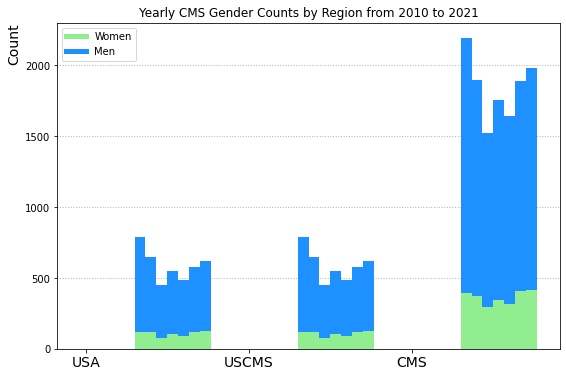

In [13]:
#@markdown ### Visualize the filtered statistics by year

width = 0.8 / len( years.value )
if countries_label == "NONE":
  x = np.arange( 2 )
else: 
  x = np.arange( 3 )

plt.figure( figsize = (3 * len(x) ,6) )
ax = plt.subplot(111)

for i, year in enumerate( list( years.value ) ):
    ax.bar( x + width * i, list( count[ year ][ "FEMALE" ].values() )[-len(x):], width,
           color = "lightgreen", zorder=3 )
    ax.bar( x + width * i, list( count[ year ][ "MALE" ].values() )[-len(x):], width,
           bottom = list( count[ year ][ "FEMALE" ].values() )[-len(x):],
           color = "dodgerblue", zorder=3 )

    
#ax.set_title( "{} to {} Gender Count for {} {} in {} working on {}".format( 
#    years.value[0], years.value[-1],
#    [ str(key) for key in author_legend if list( author.value ) == author_legend[ key ] ][0], 
#    list(activities.value), list(countries.value) + ["USCMS"], list(projects.value)
#), fontsize = 8 )
ax.set_title( "Yearly CMS Gender Counts by Region from {} to {}".format( 
    years.value[0], years.value[-1]
 ) )
ax.set_ylabel( "Count", y = 1.0, ha = "right", fontsize = 14 )
ax.set_xticks( x )
ax.set_xticklabels( [ countries_label, "USCMS", "CMS" ][-len(x):], fontsize = 14 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)
plt.show()

#Plot Author Count by Regions
__Regions__: CERN, CERN Other, France, Germany, Italy, Switzerland, United Kingdom, USA, Other States A, Other States B, RDMS


*   __CERN Other__: Austria, Belgium, Bulgaria, Finland, Greece, Hungary, Poland, Portugal, Serbia, Spain
*   __Other States A__: China, India, Iran, Korea, Malaysia, New Zealand, Pakistan, Sri Lanka, Taiwan, Thailand
*   __Other States B__: Bahrain, Brazil, Colombia, Croatia, Cyprus, Ecuador, Egypt, Estonia, Ireland, Kuwait, Lebanon, Latvia, Lithuania, Mexico, Montenegro, Oman, Qatar, Saudi Arabia, Turkey, Ukraine
*   __RDMS__: Russia, Armenia, Belarus, Georgia, Uzbekistan






In [38]:
#@markdown Select years to report:
years = widgets.SelectMultiple( options = options[ "YEARS" ], value = [ options[ "YEARS"][-1] ] )
years

SelectMultiple(index=(11,), options=('2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '…

In [54]:
#@markdown Select authorship status to report:
author_legend = {
    "AUTHORS": [ True ],
    "ALL MEMBERS": [ True, False, None ],
    "NON-AUTHORS": [ False ],
    "REPORTED MEMBERS": [ True, False ],
    "UNREPORTED MEMBERS": [ None ],
    "AUTHORS and UNREPORTED": [ True, None ],
    "NON-AUTHORS and UNREPORTED": [ False, None ]
}
author = widgets.Select( options = author_legend.keys(), value = "AUTHORS" )
author

Select(options=('AUTHORS', 'ALL MEMBERS', 'NON-AUTHORS', 'REPORTED MEMBERS', 'UNREPORTED MEMBERS', 'AUTHORS an…

In [43]:
#@markdown Select regions to report
region_key = {
    "FRANCE": ["FRANCE"],
    "GERMANY": ["GERMANY"],
    "ITALY": ["ITALY"],
    "SWITZERLAND": ["SWITZERLAND"],
    "UNITED KINGDOM": ["UNITED KINGDOM"],
    "USCMS": ["USA"],
    "CERN":["CERN","CERN-BASED"],
    "RDMS":["RUSSIA","ARMENIA","BELARUS","GEORGIA","UZBEKISTAN"],
    "CERN OTHER":["AUSTRIA","BELGIUM","BULGARIA","FINLAND","GREECE","HUNGARY","POLAND","PORTUGAL","SERBIA","SPAIN"],
    "OTHER A":["CHINA","INDIA","IRAN","KOREA","MALAYSIA","NEW ZEALAND","PAKISTAN","SRI LANKA","TAIWAN","THAILAND"],
    "OTHER B":["BAHRAIN","BRAZIL","COLOMBIA","CROATIA","CYPRUS","ECUADOR","EGYPT","ESTONIA","IRELAND","KUWAIT","LEBANON","LATVIA","LITHUANIA","MEXICO","MONTENEGRO","OMAN","QATAR","SAUDI ARABIA","TURKEY","UKRAINE"],
    "OTHER C":[],
    "INDIA":["INDIA"]
}

regions = widgets.SelectMultiple( options = region_key.keys() )
regions 

SelectMultiple(options=('FRANCE', 'GERMANY', 'ITALY', 'SWITZERLAND', 'UNITED KINGDOM', 'USCMS', 'CERN', 'RDMS'…

In [67]:
#@markdown Add region information to data

data_reg = data.copy()
for year in years.value:
  print( "Adding regions for {}...".format( year ) )
  for cms_id in data[ year ]:
    this_index = np.argwhere( institute_list[:,0] == data_reg[ year ][ cms_id ][ "INSTITUTE" ] )[0,0]
    this_country = institute_list[ this_index, 1 ].upper()
    if data_reg[ year ][ cms_id ][ "INSTITUTE" ].upper() in [ "CERN", "CERN-BASED" ]:
      this_country = "CERN"
    has_region = False
    for region in region_key.keys():
      if this_country in region_key[ region ]:
        data_reg[ year ][ cms_id ][ "REGION" ] = region
        has_region = True
        continue
    if has_region == False:
      data_reg[ year ][ cms_id ][ "REGION" ] = "OTHER C"
      if this_country not in region_key["OTHER C"]: 
        print( ">> Adding {} to Other C".format( this_country ) )
        region_key["OTHER C"].append( this_country )

Adding regions for 2015...
Adding regions for 2016...
Adding regions for 2017...
Adding regions for 2018...
Adding regions for 2019...
Adding regions for 2020...
Adding regions for 2021...


In [68]:
#@markdown Count genders by region

count_region = {
  year: {
    category: { 
      region: 0 for region in regions.value  
        } for category in [ "MALE", "FEMALE", "TOTAL", "FRACTION_F", "FRACTION_M" ]
    } for year in years.value
}

count_cms = {
    year: {
        category: 0 for category in [ "MALE", "FEMALE", "TOTAL", "FRACTION_F", "FRACTION_M" ]
    } for year in years.value
}

max_count = 0

for year in years.value:
  print( "Counting for {}...".format( year ) )
  for cms_id in data_reg[ year ]:
    if data_reg[ year ][ cms_id ][ "AUTHOR" ] in author_legend[ author.value ]: 
      for region in regions.value:
        if data_reg[ year ][ cms_id ][ "REGION" ] is region:
          if data_reg[ year ][ cms_id ][ "GENDER" ] == "M": count_region[ year ][ "MALE" ][ region ] += 1
          elif data_reg[ year ][ cms_id ][ "GENDER" ] == "F": count_region[ year ][ "FEMALE" ][ region ] += 1
          count_region[ year ][ "TOTAL" ][ region ] += 1
      if data_reg[ year ][ cms_id ][ "AUTHOR" ] in author_legend[ author.value ]:
        if data_reg[ year ][ cms_id ][ "GENDER" ] == "M": count_cms[ year ][ "MALE" ] += 1
        elif data_reg[ year ][ cms_id ][ "GENDER" ] == "F": count_cms[ year ][ "FEMALE" ] += 1
        count_cms[ year ][ "TOTAL" ] += 1

  for region in regions.value:
    if count_region[ year ][ "TOTAL" ][ region ] > 0:
      count_region[ year ][ "FRACTION_F" ][ region ] = float( count_region[ year ][ "FEMALE"][ region ] ) / float( count_region[ year ][ "TOTAL"][ region ] )
      count_region[ year ][ "FRACTION_M" ][ region ] = float( count_region[ year ][ "MALE"][ region ] ) / float( count_region[ year ][ "TOTAL"][ region ] )
    else:
      print( ">[WARN] {} has no entries".format( region ) )
  
  count_cms[ year ][ "FRACTION_F" ] = float( count_cms[ year ][ "FEMALE" ] ) / float( count_cms[ year ][ "TOTAL" ] ) if count_cms[ year ][ "TOTAL" ] > 0 else 0
  count_cms[ year ][ "FRACTION_M" ] = float( count_cms[ year ][ "MALE" ] ) / float( count_cms[ year ][ "TOTAL" ] ) if count_cms[ year ][ "TOTAL" ] > 0 else 0
  print( "[OK] Male: {} / Female: {} / Total: {}".format( count_cms[ year ][ "MALE" ], count_cms[ year ][ "FEMALE" ], count_cms[ year ][ "TOTAL" ] ) )
  if count_cms[ year ][ "TOTAL" ] > max_count: max_count = count_cms[ year ][ "TOTAL" ]

Counting for 2015...
[OK] Male: 1327 / Female: 295 / Total: 1622
Counting for 2016...
[OK] Male: 1190 / Female: 275 / Total: 1465
Counting for 2017...
[OK] Male: 1019 / Female: 244 / Total: 1263
Counting for 2018...
[OK] Male: 1126 / Female: 262 / Total: 1388
Counting for 2019...
[OK] Male: 1054 / Female: 248 / Total: 1302
Counting for 2020...
[OK] Male: 1161 / Female: 307 / Total: 1468
Counting for 2021...
[OK] Male: 1228 / Female: 313 / Total: 1541


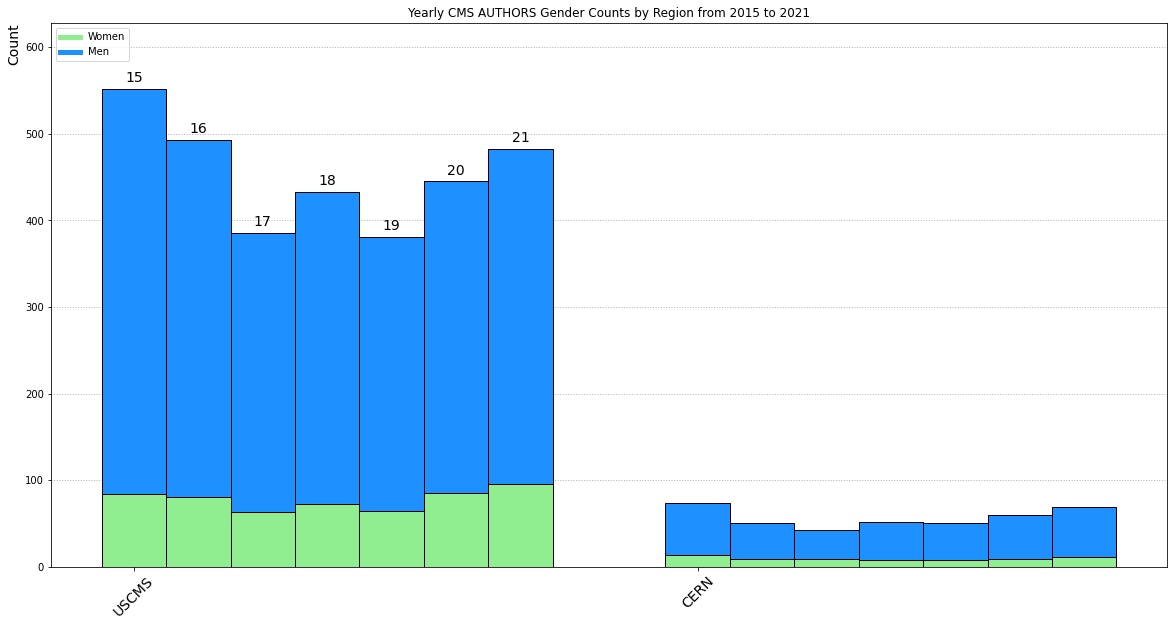

In [69]:
#@markdown ### Plot the Gender Counts by Region per Year

width = 0.8 / len( years.value )
x = np.arange( len( regions.value ) )

plt.figure( figsize = (10 * len(x) , 10) )
ax = plt.subplot(111)

for i, year in enumerate( list( years.value ) ):
    ax.bar( x + width * i, list( count_region[ year ][ "FEMALE" ].values() )[-len(x):], width,
           color = "lightgreen", edgecolor = "k", zorder=3 )
    ax.bar( x + width * i, list( count_region[ year ][ "MALE" ].values() )[-len(x):], width,
           bottom = list( count_region[ year ][ "FEMALE" ].values() )[-len(x):],
           color = "dodgerblue", edgecolor = "k", zorder=3 )
    for xi in x:
      ax.text( 
          xi + width * ( i ),
          0.005 * max_count + ( ( np.array( list( count_region[ year ][ "MALE" ].values() ) ) + np.array( list( count_region[ year ][ "FEMALE" ].values() ) ) )[xi] ), 
          year[2:], fontsize = 14, ha = "center" )
      break
    
ax.set_title( "Yearly CMS {} Gender Counts by Region from {} to {}".format( 
    author.value, years.value[0], years.value[-1]
 ) )
ax.set_ylabel( "Count", y = 1.0, ha = "right", fontsize = 14 )
ax.set_ylim(  
  0,
  1.3*( ( np.array( list( count_region[ year ][ "MALE" ].values() ) ) + np.array( list( count_region[ year ][ "FEMALE" ].values() ) ) )[xi] )
)
ax.set_xticks( x )
ax.set_xticklabels( regions.value[-len(x):], fontsize = 14, rotation = 45 )

custom_legend = [
  Line2D( [0], [0], color = "lightgreen", lw = 5 ),
  Line2D( [0], [0], color = "dodgerblue", lw = 5 )
]
ax.legend( custom_legend, [ "Women", "Men" ], loc = 2 )

ax.set_facecolor("white")
ax.grid( b=True, which="major", axis="y", color = [0.7,0.7,0.7], 
        linestyle = ":", linewidth = 1, zorder=0)
plt.show()